In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math

In [3]:
import torch.nn as nn
import torch

In [4]:
from utils import MnistData
from models import ModelManager, ModelType

In [5]:
model_loaded = ModelManager.get_trained(ModelType.MnistCnnMilano)
data = MnistData(True)

In [37]:
max_norm = 50 / 255  # kappa - the radius of L_\infinity ball around benign example
step_size = 1e-2  # alpha - the size of the step

In [29]:
def clip(benign_examples: torch.Tensor, adversarial_examples: torch.Tensor, max_norm, minimum=0, maximum=1):
    difference = adversarial_examples - benign_examples
    difference = difference.detach()
    difference.apply_(lambda x: x if (abs(x) < max_norm) else (-1 if x < 0 else 1 ) * max_norm)
    clipped_stage_one = benign_examples + difference
    clipped_stage_one = clipped_stage_one.detach()
    clipped_stage_one.apply_(lambda x: maximum if x> maximum else (minimum if x < minimum else x))
    return clipped_stage_one

In [38]:
images, labels = data.get_training_batch(1000)
benign_images = images
for step in range(math.floor(min(max_norm * 4 * 255, max_norm * 255 * 1.25))):
    images.requires_grad = True
    if step % 10 == 0:
        print(f'--- {step} ---')
    if images.grad is not None:
        images.grad.zero_()
    loss = nn.CrossEntropyLoss()(model_loaded(images), labels)
    loss.backward()
    images = clip(benign_images, images + step_size * images.grad.apply_(lambda x: 1 if x >= 0 else -1), max_norm)
altered_training_images = images

--- 0 ---
--- 10 ---
--- 20 ---
--- 30 ---
--- 40 ---
--- 50 ---
--- 60 ---


In [20]:
def get_prediction(model, image):
    my_image = image.unsqueeze(0)
    pred = model(my_image)
    maxout = max(pred[0])
    for j in range(10):
        if pred[0, j] == maxout:
            return j, maxout

In [39]:
possible_adversarials = []
for i in range(len(altered_training_images)):
    prediction, confidence = get_prediction(model_loaded, altered_training_images[i])
    original_prediction, original_confidence = get_prediction(model_loaded, benign_images[i])
    if prediction != labels[i] and original_prediction == labels[i]:
        params = {"Label": labels[i], "Prediction": prediction, "Confidence": confidence,
                  "Index": i, "OriginalPrediction": original_prediction, "OriginalConfidence": original_confidence}
        possible_adversarials.append(params)

In [40]:
len(possible_adversarials)

847

In [23]:
from matplotlib import pyplot as plt
import numpy as np

In [24]:
def display(image):
    first_image = image[0].reshape((28 * 28,)).detach()
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap="gray")
    plt.show()

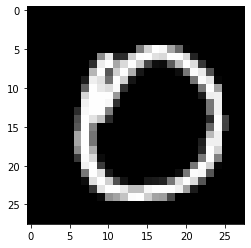

+++++


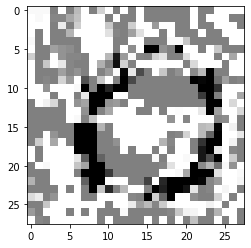

=====


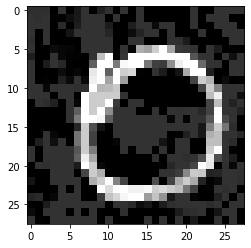

Label: 0, Prediction: 5, Confidence: 0.9999994039535522
Original prediction: 0, Original confidence: 1.0


In [42]:
adversarial = possible_adversarials[0]
original_image = benign_images[adversarial["Index"]]
altered_image = altered_training_images[adversarial["Index"]]
mask = altered_image - original_image
# mask = mask * 255
# original_image = original_image * 255
# altered_image = altered_image * 255
display(original_image)
print("+++++")
display(mask)
print("=====")
display(altered_image)
print(f"Label: {adversarial['Label']}, Prediction: {adversarial['Prediction']}, Confidence: {adversarial['Confidence']}")
print(f"Original prediction: {adversarial['OriginalPrediction']}, Original confidence: {adversarial['OriginalConfidence']}")